# 2D *tobac* Tutorial: GOES-16 ABI Data

This tutorial will demonstrate how to use GOES-16 ABI IR data to detect and track cloud features with *tobac*. Because this tutorial is entirely using 2D spatial data, 

In [8]:
%matplotlib inline
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import goes_conv
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import datetime
import pandas as pd
import cartopy.feature as cfeature
import tobac

### Data Prep

First, we will start with a single time/file. Then we will demonstrate expanding this to multiple times. 

In [35]:
# Download example file 1 from here: https://noaa-goes16.s3.amazonaws.com/ABI-L2-MCMIPC/2021/178/14/OR_ABI-L2-MCMIPC-M6_G16_s20211781401171_e20211781403549_c20211781404049.nc
in_goes_test = xr.open_dataset('./OR_ABI-L2-MCMIPC-M6_G16_s20211781401171_e20211781403549_c20211781404049.nc')

In [17]:
in_goes_test

<xarray.Dataset>
Dimensions:                                 (y: 1500, x: 2500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1282 ... 0.04427
  * x                                       (x) float32 -0.1013 ... 0.03861
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-27T14:04:04.9Z
    time_coverage_start:       2021-06-27T14:01:17.1Z
    time_coverage_end:         2021-06-27T14:03:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        e5f1e926-22be-4065-aba8-36b2c0a55453

GOES data comes in radian coordinates from the satellite. There are many different ways of gridding these data, but we've included a little helper function here that should work. 

In [23]:
llons, llats  = goes_conv.lat_lon_reproj(in_goes_test)

Since we are only interested in one channel here, let's extract out those data. This will also make our lives easier when switching over to Iris.

In [81]:
in_goes_test_for_tobac = xr.Dataset(data_vars=
    {
        "C10": (("time", "Y", "X"), np.expand_dims(in_goes_test['CMI_C10'].values, axis=0)),
    },
    coords=
    {"time": [in_goes_test['time_bounds'].mean().values],
    "lon": (["Y", "X"], llons),
    "lat": (["Y", "X"], llats)},
)

*tobac* currently only supports Iris as its data input type. Fortunately, it is relatively easy to convert Xarray to Iris.

In [27]:
iris_var = in_goes_test_for_tobac['C10'].to_iris()

In [28]:
iris_var

<iris 'Cube' of C10 / (unknown) (time: 1; -- : 1500; -- : 2500)>

### Feature Detection

First, let's set our parameters for feature detection. 

In [31]:
# Keyword arguments for the feature detection step
# See: https://tobac--150.org.readthedocs.build/en/150/threshold_detection_parameters.html for a more thorough description of these parameters.
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=1.5
parameters_features['n_erosion_threshold']=2

parameters_features['n_min_threshold']=10
parameters_features['target']='minimum'
parameters_features['threshold']=[230, 220, 210, 200]


Let's run feature detection. While this is only running on one file, 

In [42]:
print('starting feature detection')
# GOES-16 isn't *quite* 2km resolution, but this is reasonably close. 
dxy=2000
Features=tobac.feature_detection_multithreshold(iris_var,dxy,**parameters_features)

starting feature detection


In [36]:
# This is our list of detected features. 
Features

frame  idx       hdim_1       hdim_2   num  threshold_value  feature  \
0        0    1     0.859961  2351.036476    27              230        1   
1        0    2    11.548948  2383.003738   391              230        2   
2        0    3     1.459504  2469.359926    37              230        3   
3        0    5     7.769386  1406.709740    12              230        4   
4        0    6    16.143667  1524.769058   205              230        5   
..     ...  ...          ...          ...   ...              ...      ...   
341      0  642  1454.127559  1549.377151    23              210      342   
342      0  643  1456.875374  1765.249309    16              210      343   
343      0  644  1486.810147  1518.330103  1238              210      344   
344      0  645  1481.156365   474.592396    20              210      345   
345      0  647  1351.388311   308.201823    13              200      346   

                    time              timestr                   lat  \
0    2021-06-27 14:02:36  2021-06-27 14:02:36   [51.07443181574466]   
1    2021-06-27 14:02:36  2021-06-27 14:02:36   [50.72345103206636]   
2    2021-06-27 14:02:36  2021-06-27 14:02:36   [51.25065735230365]   
3    2021-06-27 14:02:36  2021-06-27 14:02:36   [50.64430639841211]   
4    2021-06-27 14:02:36  2021-06-27 14:02:36  [50.237459154258985]   
..                   ...                  ...                   ...   
341  2021-06-27 14:02:36  2021-06-27 14:02:36  [15.440051417974637]   
342  2021-06-27 14:02:36  2021-06-27 14:02:36   [15.37761637042772]   
343  2021-06-27 14:02:36  2021-06-27 14:02:36   [14.81602626226577]   
344  2021-06-27 14:02:36  2021-06-27 14:02:36  [15.189983462564477]   
345  2021-06-27 14:02:36  2021-06-27 14:02:36  [17.854789992849266]   

                       lon  
0     [-58.02799696573499]  
1     [-57.13791718531517]  
2       [-54.017825610391]  
3     [-87.38189743047329]  
4     [-83.62320092308335]  
..                     ...  
341   [-79.90279344898228]  
342   [-75.83219154443103]  
343   [-80.47132221722855]  
344  [-101.50979818362266]  
345  [-105.89703491387974]  

[346 rows x 11 columns]

In [37]:
#get cartopy projection for plotting parts of figure
proj = ccrs.PlateCarree()


In [38]:
goes_xformed_pts = proj.transform_points(src_crs = ccrs.PlateCarree(), x=llons, y=llats)
goes_proj_x = goes_xformed_pts[...,0]
goes_proj_y = goes_xformed_pts[...,1]


c:\Users\sfreeman\miniconda3\envs\tobac_stable\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\sfreeman\miniconda3\envs\tobac_stable\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


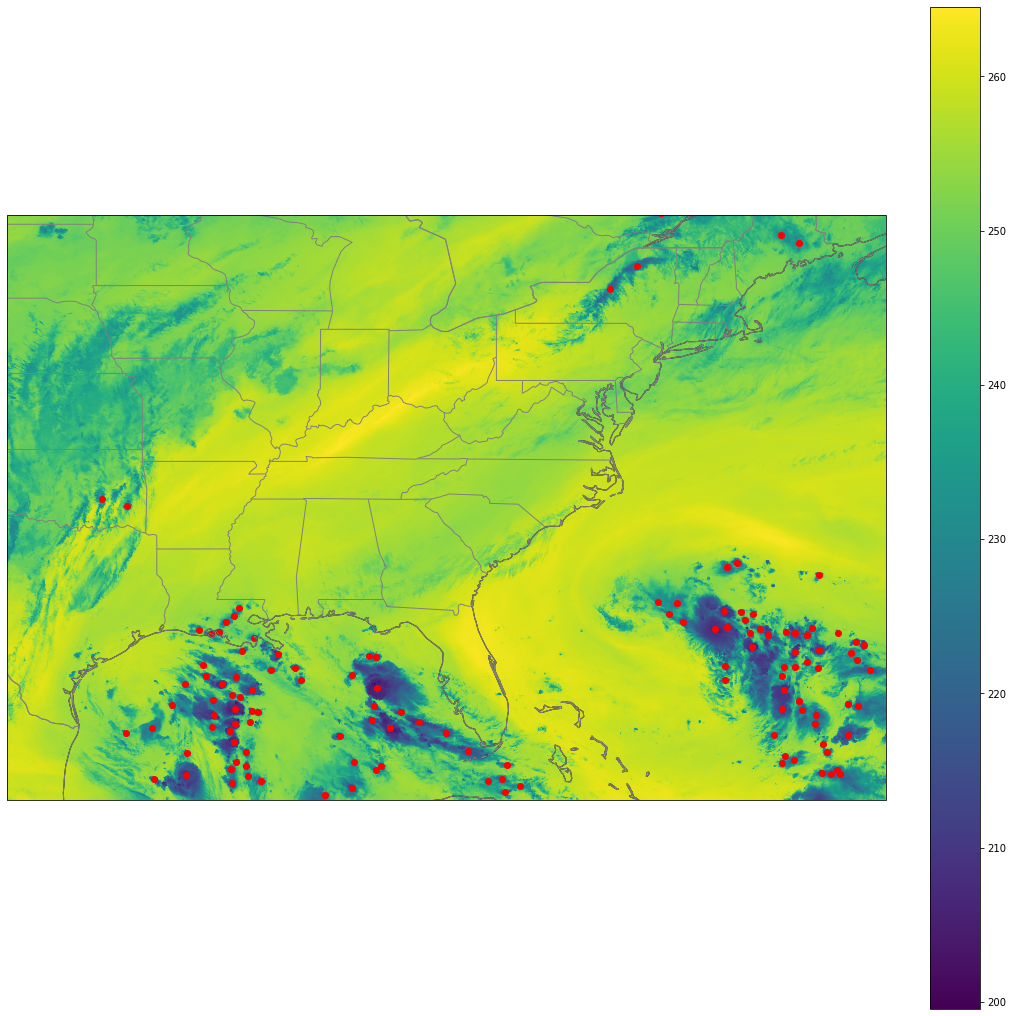

In [39]:
#make the figure
fig1 = plt.figure(figsize = (14,14), constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

f1_goes_1 = fig1.add_subplot(spec1[0, 0], projection=proj)
#f1_goes_1.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', zorder=3)
# Label the end-points of the gridlines using the custom tick makers:
#f1_goes_1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#f1_goes_1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
f1_goes_1.coastlines(resolution='50m')
#f1_goes_1.borders(resolution='50m')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')

f1_goes_1.add_feature(states_provinces, edgecolor='gray')
f1_goes_1.add_feature(country_borders, edgecolor='gray')

#this works for squares onlu, figure out non-squares.
min_x = 400
min_y = 100
max_x = 2500
max_y = 1100


cmesh = f1_goes_1.pcolormesh(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, in_goes_test['CMI_C10'][min_y:max_y, min_x:max_x].T)
plt.colorbar(cmesh)

#f1_goes_1.scatter(goes_proj_x[min_y:max_y, min_x:max_x], goes_proj_y[min_y:max_y, min_x:max_x], )
f1_goes_1.scatter(Features['lon'],Features['lat'], transform=ccrs.PlateCarree(), color='r')
f1_goes_1.set_extent([-100, -65, 23, 45])

### Segmentation

Segmentation associates each feature with an area of another variable around it that is either the same variable or a different variable.

First, we will try to associate the areas of the same variable with a minimum threshold of 230K. 

In [75]:
parameters_segmentation = dict()
parameters_segmentation['threshold'] = 230
parameters_segmentation['target'] = 'minimum'

In [76]:
print('starting segmentation')
dxy=2000
segmentation, features_from_seg=tobac.segmentation.segmentation(Features, iris_var, dxy,**parameters_segmentation)

starting segmentation


c:\Users\sfreeman\miniconda3\envs\tobac_stable\lib\site-packages\cartopy\mpl\geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
c:\Users\sfreeman\miniconda3\envs\tobac_stable\lib\site-packages\cartopy\mpl\geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


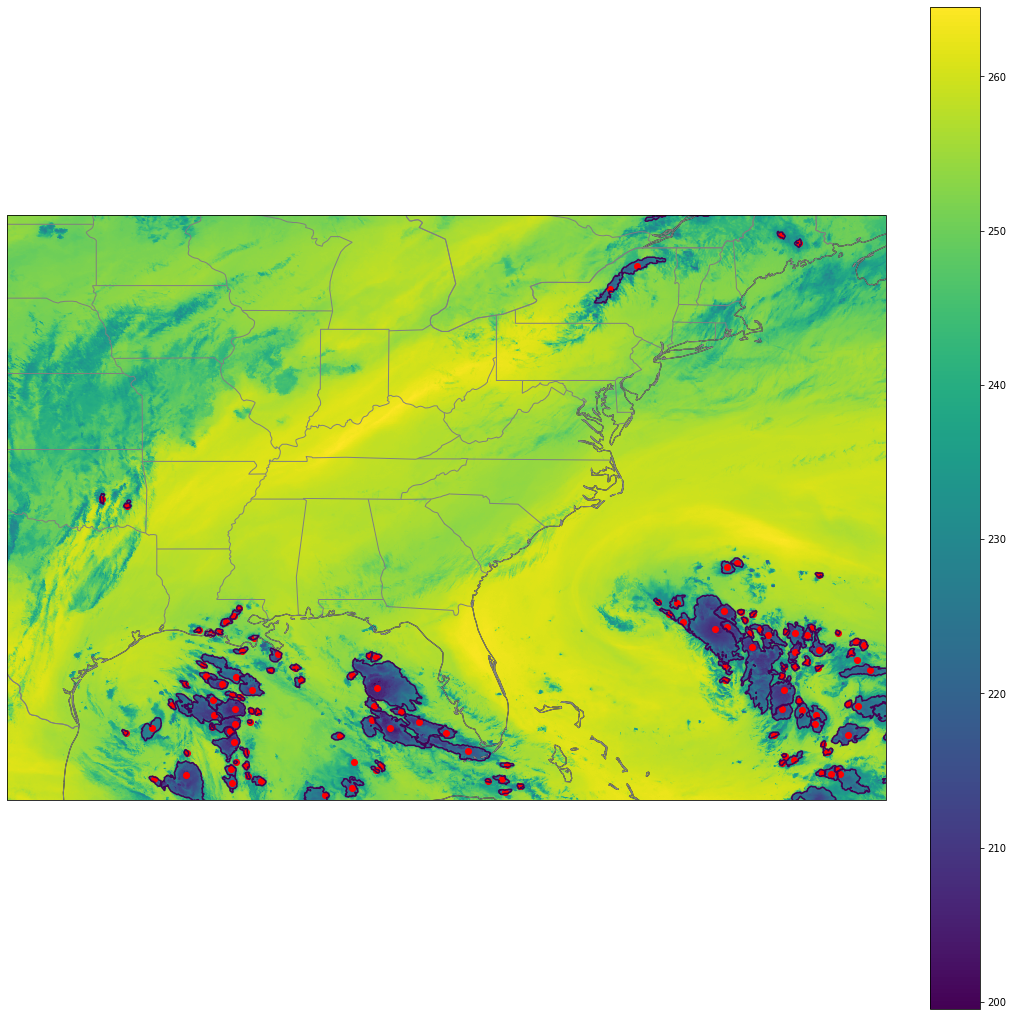

In [78]:
#make the figure
fig1 = plt.figure(figsize = (14,14), constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

f1_goes_1 = fig1.add_subplot(spec1[0, 0], projection=proj)
#f1_goes_1.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', zorder=3)
# Label the end-points of the gridlines using the custom tick makers:
#f1_goes_1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#f1_goes_1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
f1_goes_1.coastlines(resolution='50m')
#f1_goes_1.borders(resolution='50m')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')

f1_goes_1.add_feature(states_provinces, edgecolor='gray')
f1_goes_1.add_feature(country_borders, edgecolor='gray')

#this works for squares onlu, figure out non-squares.
min_x = 400
min_y = 100
max_x = 2500
max_y = 1100


cmesh = f1_goes_1.pcolormesh(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, in_goes_test['CMI_C10'][min_y:max_y, min_x:max_x].T)
segmentation_data = segmentation.core_data()[min_y:max_y, min_x:max_x].T
# Loop through each segmented area to draw each one individually
for unique_val in np.unique(segmentation_data):
        if unique_val == 0:
                continue
        curr_seg_mask = segmentation_data == unique_val
        curr_seg_mask = curr_seg_mask.astype(np.int32)
        cl = f1_goes_1.contour(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, curr_seg_mask, levels=[1,], colors='r')
plt.colorbar(cmesh)

#f1_goes_1.scatter(goes_proj_x[min_y:max_y, min_x:max_x], goes_proj_y[min_y:max_y, min_x:max_x], )
f1_goes_1.scatter(Features['lon'],Features['lat'], transform=ccrs.PlateCarree(), color='r')
f1_goes_1.set_extent([-100, -65, 23, 45])

#### Segmentation on a different variable, same grid

In [82]:
# Let's try to segment on visible satellite from our IR detected features.
in_goes_test_for_tobac_vis = xr.Dataset(data_vars=
    {
        "C02": (("time", "Y", "X"), np.expand_dims(in_goes_test['CMI_C02'].values, axis=0)),
    },
    coords=
    {"time": [in_goes_test['time_bounds'].mean().values],
    "lon": (["Y", "X"], llons),
    "lat": (["Y", "X"], llats)},
)

In [85]:
iris_var_vis = in_goes_test_for_tobac_vis['C02'].to_iris()

In [91]:
parameters_segmentation = dict()
parameters_segmentation['threshold'] = 0.4
parameters_segmentation['target'] = 'maximum'

In [92]:
print('starting segmentation on visible satellite')
dxy=2000
segmentation, features_from_seg=tobac.segmentation.segmentation(Features, iris_var_vis, dxy,**parameters_segmentation)

starting segmentation on visible satellite


c:\Users\sfreeman\miniconda3\envs\tobac_stable\lib\site-packages\cartopy\mpl\geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


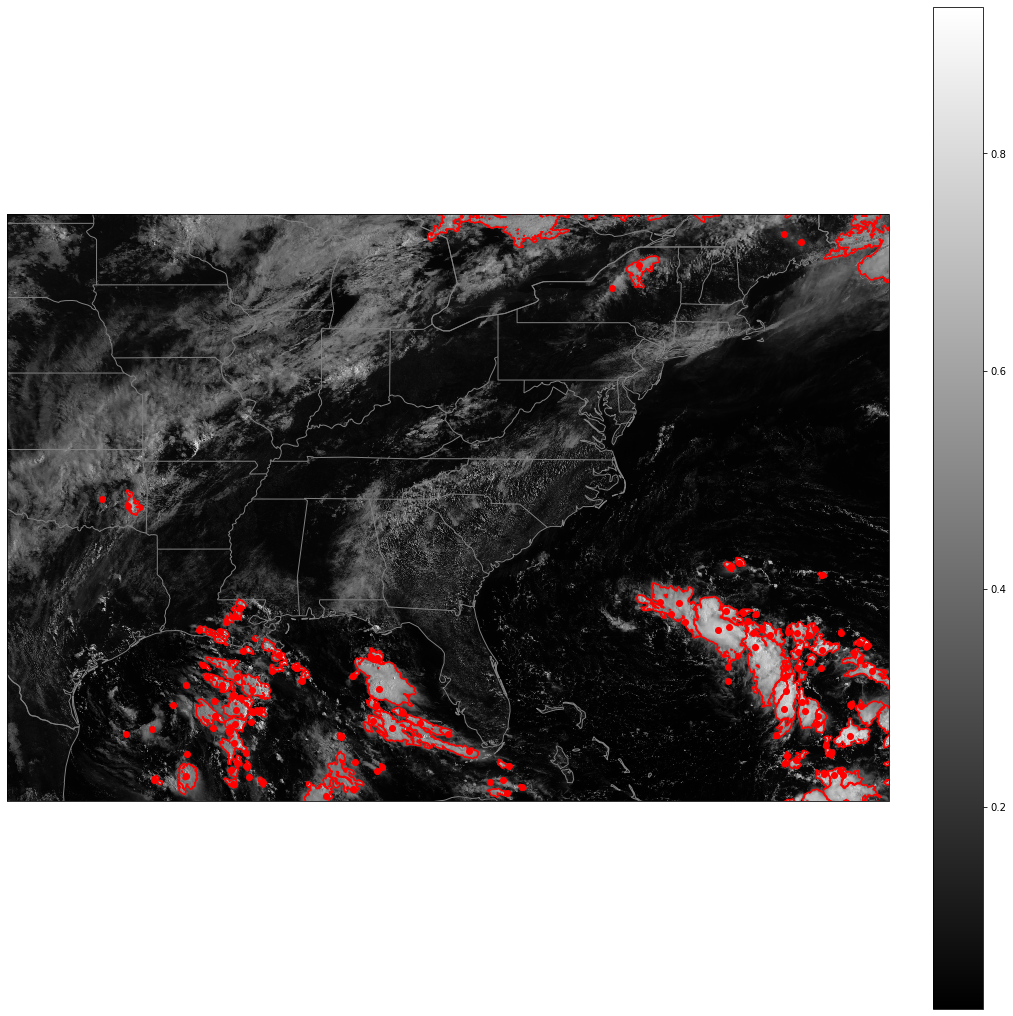

In [93]:
#make the figure
fig1 = plt.figure(figsize = (14,14), constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

f1_goes_1 = fig1.add_subplot(spec1[0, 0], projection=proj)
#f1_goes_1.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', zorder=3)
# Label the end-points of the gridlines using the custom tick makers:
#f1_goes_1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#f1_goes_1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
f1_goes_1.coastlines(resolution='50m')
#f1_goes_1.borders(resolution='50m')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')

f1_goes_1.add_feature(states_provinces, edgecolor='gray')
f1_goes_1.add_feature(country_borders, edgecolor='gray')

#this works for squares onlu, figure out non-squares.
min_x = 400
min_y = 100
max_x = 2500
max_y = 1100


cmesh = f1_goes_1.pcolormesh(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, in_goes_test['CMI_C02'][min_y:max_y, min_x:max_x].T, cmap='binary_r')
segmentation_data = segmentation.core_data()[min_y:max_y, min_x:max_x].T
# Loop through each segmented area to draw each one individually
for unique_val in np.unique(segmentation_data):
        if unique_val == 0:
                continue
        curr_seg_mask = segmentation_data == unique_val
        curr_seg_mask = curr_seg_mask.astype(np.int32)
        cl = f1_goes_1.contour(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, curr_seg_mask, levels=[1,], colors='r')
plt.colorbar(cmesh)

#f1_goes_1.scatter(goes_proj_x[min_y:max_y, min_x:max_x], goes_proj_y[min_y:max_y, min_x:max_x], )
f1_goes_1.scatter(Features['lon'],Features['lat'], transform=ccrs.PlateCarree(), color='r')
f1_goes_1.set_extent([-100, -65, 23, 45])

## Tracking

For tracking, we will clearly need more than one timestep. Now, let's load in the 

In [94]:
import urllib.request
in_file_names = ['OR_ABI-L2-MCMIPC-M6_G16_s20211781401171_e20211781403549_c20211781404049.nc', 'OR_ABI-L2-MCMIPC-M6_G16_s20211781406171_e20211781408549_c20211781409055.nc',
                'OR_ABI-L2-MCMIPC-M6_G16_s20211781411171_e20211781413544_c20211781414055.nc', 'OR_ABI-L2-MCMIPC-M6_G16_s20211781416171_e20211781418555_c20211781419046.nc',
                'OR_ABI-L2-MCMIPC-M6_G16_s20211781421171_e20211781423544_c20211781424047.nc', 'OR_ABI-L2-MCMIPC-M6_G16_s20211781426171_e20211781428544_c20211781429045.nc',
                'OR_ABI-L2-MCMIPC-M6_G16_s20211781431171_e20211781433544_c20211781434046.nc', 'OR_ABI-L2-MCMIPC-M6_G16_s20211781436171_e20211781438555_c20211781439046.nc',
                'OR_ABI-L2-MCMIPC-M6_G16_s20211781441171_e20211781443549_c20211781444049.nc', 'OR_ABI-L2-MCMIPC-M6_G16_s20211781446171_e20211781448544_c20211781449043.nc',
                'OR_ABI-L2-MCMIPC-M6_G16_s20211781451171_e20211781453544_c20211781454048.nc', 'OR_ABI-L2-MCMIPC-M6_G16_s20211781456171_e20211781458550_c20211781459045.nc']
for in_file in in_file_names:
    print("Downloading "+in_file)
    urllib.request.urlretrieve("https://noaa-goes16.s3.amazonaws.com/ABI-L2-MCMIPC/2021/178/14/"+in_file, "./goes_data/"+in_file)


In [95]:
import glob
# Import all of our data into an xarray
in_goes_files = sorted(glob.glob('./goes_data/*.nc', recursive=True))

We need to combine these GOES-16 files into one large Xarray dataset. 

In [98]:
in_goes_ds = list()

for in_goes_fn in in_goes_files:
    #print(in_goes_fn)
    in_goes_ds.append(xr.open_dataset(in_goes_fn))
    
#get common lats/lons

llons, llats  = goes_conv.lat_lon_reproj(in_goes_ds[0])

full_goes_data = np.zeros((len(in_goes_ds),llons.shape[0], llons.shape[1]))
goes_times = list()

for i, in_goes_file in enumerate(in_goes_ds):
    full_goes_data[i] = in_goes_file['CMI_C10'].values
    goes_times.append(pd.to_datetime(in_goes_file['time_bounds'].mean().values).to_pydatetime())
#pd.to_datetime(test_dt).to_pydatetime()
in_goes_for_tobac = xr.Dataset(data_vars=
    {
        "C10": (("time", "Y", "X"), full_goes_data,)
    },
    coords=
    {"time": goes_times,
    "lon": (["Y", "X"], llons),
    "lat": (["Y", "X"], llats)},
)


c:\Users\sfreeman\Documents\Research\tobac\camp2ex-tobac-tutorial\goes_conv.py:31: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
c:\Users\sfreeman\miniconda3\envs\tobac_stable\lib\site-packages\IPython\core\interactiveshell.py:3398: UserWarning: Discarding nonzero nanoseconds in conversion.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\sfreeman\miniconda3\envs\tobac_stable\lib\site-packages\IPython\core\interactiveshell.py:3398: UserWarning: Discarding nonzero nanoseconds in conversion.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\sfreeman\miniconda3\envs\tobac_stable\lib\site-packages\IPython\core\interactiveshell.py:3398: UserWarning: Discarding nonzero nanoseconds in conversion.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\sfreeman\miniconda3\envs\tobac_stable\lib\site-packages\IPython\core\interactiveshell.py:3398: UserWarning: Discarding nonzero nanoseconds i

As before, we will convert our input data to Iris

In [99]:
iris_var = in_goes_for_tobac['C10'].to_iris()

In [100]:
# Keyword arguments for the feature detection step (same as before)
# See: https://tobac--150.org.readthedocs.build/en/150/threshold_detection_parameters.html for a more thorough description of these parameters.
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=1.5
parameters_features['n_erosion_threshold']=2

parameters_features['n_min_threshold']=10
parameters_features['target']='minimum'
parameters_features['threshold']=[230, 220, 210, 200]


In [101]:
# Feature detection and save results to file:
print('starting feature detection')
dxy=2000
Features=tobac.feature_detection_multithreshold(iris_var,dxy,**parameters_features)

starting feature detection


In [102]:
Features

frame  idx       hdim_1       hdim_2   num  threshold_value  feature  \
0         0    1     0.859960  2351.036476    27              230        1   
1         0    2    11.548947  2383.003737   391              230        2   
2         0    3     1.459503  2469.359925    37              230        3   
3         0    5     7.769385  1406.709742    12              230        4   
4         0    6    16.143668  1524.769062   205              230        5   
...     ...  ...          ...          ...   ...              ...      ...   
4209     11  662  1476.054404  1521.294924  2530              210     4210   
4210     11  664  1468.995254  2184.779155    25              210     4211   
4211     11  665  1482.729504   459.291581    39              210     4212   
4212     11  666  1494.613680   454.560435    27              210     4213   
4213     11  668  1343.475116   314.564605   144              200     4214   

                     time              timestr                   lat  \
0     2021-06-27 14:02:36  2021-06-27 14:02:36   [51.07443185236474]   
1     2021-06-27 14:02:36  2021-06-27 14:02:36   [50.72345105057844]   
2     2021-06-27 14:02:36  2021-06-27 14:02:36   [51.25065735502024]   
3     2021-06-27 14:02:36  2021-06-27 14:02:36  [50.644306438492606]   
4     2021-06-27 14:02:36  2021-06-27 14:02:36   [50.23745911702278]   
...                   ...                  ...                   ...   
4209  2021-06-27 14:57:36  2021-06-27 14:57:36  [15.021689278589887]   
4210  2021-06-27 14:57:36  2021-06-27 14:57:36  [15.165403813108842]   
4211  2021-06-27 14:57:36  2021-06-27 14:57:36  [15.166320263848583]   
4212  2021-06-27 14:57:36  2021-06-27 14:57:36  [14.936432242902093]   
4213  2021-06-27 14:57:36  2021-06-27 14:57:36  [18.009805024621294]   

                        lon  
0     [-58.027996960488316]  
1      [-57.13791720371623]  
2      [-54.01782561824409]  
3      [-87.38189737971507]  
4       [-83.6232008045906]  
...                     ...  
4209   [-80.42155928261907]  
4210   [-67.92310064952161]  
4211  [-101.84813624728024]  
4212  [-101.91615130480562]  
4213  [-105.77992811357316]  

[4214 rows x 11 columns]

In [105]:
parameters_linking={}
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']=200
parameters_linking['memory']=2
parameters_linking['time_cell_min']=5*60
parameters_linking['method_linking']='predict'
parameters_linking['v_max']=30


In [106]:
# Perform linking and save results:
Track= tobac.linking_trackpy(Features,None,dt=5*60,dxy=1000,**parameters_linking)


Frame 11: 355 trajectories present.


In [113]:
Track

frame  idx       hdim_1       hdim_2   num  threshold_value  feature  \
0         0    1     0.859960  2351.036476    27              230        1   
1         0    2    11.548947  2383.003737   391              230        2   
2         0    3     1.459503  2469.359925    37              230        3   
3         0    5     7.769385  1406.709742    12              230        4   
4         0    6    16.143668  1524.769062   205              230        5   
...     ...  ...          ...          ...   ...              ...      ...   
4209     11  662  1476.054404  1521.294924  2530              210     4210   
4210     11  664  1468.995254  2184.779155    25              210     4211   
4211     11  665  1482.729504   459.291581    39              210     4212   
4212     11  666  1494.613680   454.560435    27              210     4213   
4213     11  668  1343.475116   314.564605   144              200     4214   

                     time              timestr                   lat  \
0     2021-06-27 14:02:36  2021-06-27 14:02:36   [51.07443185236474]   
1     2021-06-27 14:02:36  2021-06-27 14:02:36   [50.72345105057844]   
2     2021-06-27 14:02:36  2021-06-27 14:02:36   [51.25065735502024]   
3     2021-06-27 14:02:36  2021-06-27 14:02:36  [50.644306438492606]   
4     2021-06-27 14:02:36  2021-06-27 14:02:36   [50.23745911702278]   
...                   ...                  ...                   ...   
4209  2021-06-27 14:57:36  2021-06-27 14:57:36  [15.021689278589887]   
4210  2021-06-27 14:57:36  2021-06-27 14:57:36  [15.165403813108842]   
4211  2021-06-27 14:57:36  2021-06-27 14:57:36  [15.166320263848583]   
4212  2021-06-27 14:57:36  2021-06-27 14:57:36  [14.936432242902093]   
4213  2021-06-27 14:57:36  2021-06-27 14:57:36  [18.009805024621294]   

                        lon  cell       time_cell  
0     [-58.027996960488316]     1 0 days 00:00:00  
1      [-57.13791720371623]     2 0 days 00:00:00  
2      [-54.01782561824409]     3 0 days 00:00:00  
3      [-87.38189737971507]     4 0 days 00:00:00  
4       [-83.6232008045906]     5 0 days 00:00:00  
...                     ...   ...             ...  
4209   [-80.42155928261907]   646 0 days 00:15:00  
4210   [-67.92310064952161]   539 0 days 00:30:00  
4211  [-101.84813624728024]   735 0 days 00:05:00  
4212  [-101.91615130480562]   200 0 days 00:55:00  
4213  [-105.77992811357316]   346 0 days 00:55:00  

[4214 rows x 13 columns]

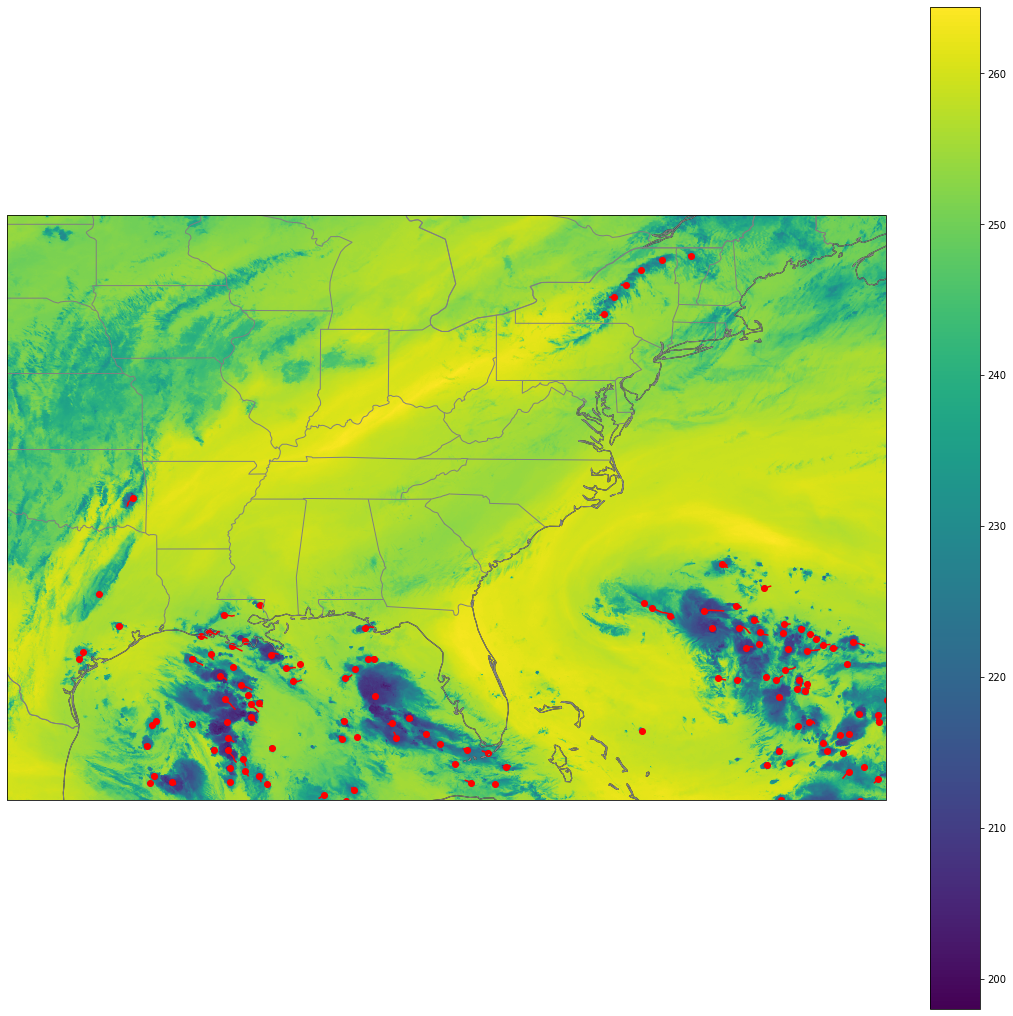

In [125]:
#make the figure
fig1 = plt.figure(figsize = (14,14), constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

f1_goes_1 = fig1.add_subplot(spec1[0, 0], projection=proj)
#f1_goes_1.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', zorder=3)
# Label the end-points of the gridlines using the custom tick makers:
#f1_goes_1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#f1_goes_1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
f1_goes_1.coastlines(resolution='50m')
#f1_goes_1.borders(resolution='50m')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')

f1_goes_1.add_feature(states_provinces, edgecolor='gray')
f1_goes_1.add_feature(country_borders, edgecolor='gray')

#this works for squares onlu, figure out non-squares.
min_x = 400
min_y = 100
max_x = 2500
max_y = 1100


cmesh = f1_goes_1.pcolormesh(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, in_goes_for_tobac['C10'][-1,min_y:max_y, min_x:max_x].T)
plt.colorbar(cmesh)

curr_goes_time = Features['time'].max()
features_at_time = Track[Track['time']== curr_goes_time]
cells_at_time = features_at_time[features_at_time['cell']!=-1]
#f1_goes_1.scatter(goes_proj_x[min_y:max_y, min_x:max_x], goes_proj_y[min_y:max_y, min_x:max_x], )
f1_goes_1.scatter(features_at_time['lon'],features_at_time['lat'], transform=ccrs.PlateCarree(), color='r')
track_before_time = Track[np.logical_and(Track['cell'].isin(np.unique(cells_at_time['cell'])),
                                                Track['time']<=curr_goes_time+datetime.timedelta(seconds=5))]
track_lats = track_before_time.groupby('cell')['lat'].apply(list)
track_lons = track_before_time.groupby('cell')['lon'].apply(list)

for track_lat_list, track_lon_list in zip(track_lats.values, track_lons.values):
        f1_goes_1.plot(np.array(track_lon_list).flatten(), 
                        np.array(track_lat_list).flatten(), transform=ccrs.PlateCarree(), color='r')
f1_goes_1.set_extent([-100, -65, 23, 45])